# Understanding Fairness Through Analyzing IBM's AIF360

#### Welcome to a introductory module to IBM's AIF360. AIF360 is a AI Fairness package that allows users to evaluate their models for bias during preprocessing, during processing and post-processing. Furthermore, the package allows interference with the model in the three stages mentioned afore, and also serves as a tool to create fairness in your own AI or ML model.

### Importing Packages and Data

In [1]:
%%bash
pip install aif360
pip install eli5

  Using cached https://files.pythonhosted.org/packages/54/a7/de16a858cbd70d9d7b9c79c06286d79bcc6ca58507f919c656e8c324286c/aif360-0.2.3-py3-none-any.whl


In [84]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
# setting random seed
np.random.seed(218)
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import DatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

#### We will be using the AdultDataSet which serves as a CENSUS income dataset for adults with demographic information. The sensitive variable, or in other words, the variable that creates the biased "priviledge" is male.

In [3]:
single_protected = ['sex'] 
single_privileged = [['Male']]
ad = AdultDataset(protected_attribute_names=single_protected,
                  privileged_classes = single_privileged, 
                  categorical_features=[], 
                  # even if the priviledged features are not specified, they are kept
                  features_to_keep=['age', 'education-num'])
print(ad.feature_names)
print(ad.label_names)

['age', 'education-num', 'sex']
['income-per-year']


/opt/conda/lib/python3.7/site-packages/aif360/datasets/standard_dataset.py:121: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  priv = np.logical_or.reduce(np.equal.outer(vals, df[attr]))
/opt/conda/lib/python3.7/site-packages/aif360/datasets/standard_dataset.py:142: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  df[label_name]))


In [4]:
dataset_orig_train, dataset_orig_test = ad.split([0.7], shuffle=True)
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

#### Explore the Data

In [5]:
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 3)


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'education-num', 'sex']


#### After we assign the priviledged and under-priviledged groups, we calculate the baseline fairness.

In [6]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % 
      metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.192812


#### This value shows that there is a mean difference between priviledged and underpriviledged groups, and the biad towards the privildeged group.

# Introduction of Fainess Algorithm: Inprocessing

#### I will be introducing, executing and walking you through one of the inprocessing techniques that IBM AI360 has created to introduce fairness to the model. The interesting aspect of inprocess algorithm is the intervention the algorithm makes in the model, not post or pre analysis. 

#### Meta Fair Classifier takes the fairness metric, BinaryLabelDatasetMetric, as an input and optimizes the algorithm for it. It is essentially passing the fairness metric as a loss function, and trianing the model, while sacrificing from some of the accuracy, to be more fair. The example code for this introductory modelu is inspired by https://github.com/IBM/AIF360/blob/master/aif360/algorithms/inprocessing/meta_fair_classifier.py.

#### Below we create the MetaFairClassifier class, and then create the fit and predict functions for the model. Here, we train the biased model, where algorithm has a tau of 0, motivating it to not be fair:

In [7]:
import numpy as np
import copy
from aif360.algorithms import Transformer
from aif360.algorithms.inprocessing.celisMeta.FalseDiscovery import FalseDiscovery
from aif360.algorithms.inprocessing.celisMeta.StatisticalRate import StatisticalRate
from aif360.algorithms.inprocessing.meta_fair_classifier import MetaFairClassifier

mfc = MetaFairClassifier(tau=0, sensitive_attr="sex")
mfc.fit(dataset_orig_train)

Import error: No module named 'tensorflow'


#### Make Predictions

In [8]:
dataset_bias_test = mfc.predict(dataset_orig_test)

#### Assess Bias

In [9]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_bias_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % 
      metric_orig_train.mean_difference())
print("We can see that the mean outcome is still biased, towards the variable as before - sex: Male.")

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.062442
We can see that the mean outcome is still biased, towards the variable as before - sex: Male.


#### Accuracy of the Unconstrained Model

In [10]:
predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in list(dataset_bias_test.labels)]
y_test = np.array([1 if y == [dataset_orig_train.favorable_label] else -1 for y in dataset_orig_test.labels])
print("Accuracy Score:", round(accuracy_score(predictions, y_test),3))

Accuracy Score: 0.778


#### Now we will change the tau values in the algorithm to introduce fairness into the model, to see how the accuracy score and the fairness metric changes with it.

In [11]:
tau_list = np.linspace(0.01, 0.90, 5)
accuracies = []
mean_difference = []
for tau in tau_list:
    print("#########################################")
    print("Tau: %.2f" % tau)
    mfc = MetaFairClassifier(tau=tau, sensitive_attr="sex")
    mfc.fit(dataset_orig_train)
    predictions_mfc = mfc.predict(dataset_orig_test)
    pred_labels = predictions_mfc.labels
    predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in pred_labels]
    metric_orig_train = BinaryLabelDatasetMetric(predictions_mfc, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    mean_diff = metric_orig_train.mean_difference()
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % mean_diff)
    acc = accuracy_score(predictions, y_test)
    print("Test Accuracy Score:", round(acc,3))
    accuracies.append(acc)
    mean_difference.append(mean_diff)

#########################################
Tau: 0.01
Training Accuracy:  0.6112784813829009 , Training gamma:  0.6925396834753267
Difference in mean outcomes between unprivileged and privileged groups = -0.119845
Test Accuracy Score: 0.613
#########################################
Tau: 0.23
Training Accuracy:  0.6010705197578168 , Training gamma:  0.688744107329693
Difference in mean outcomes between unprivileged and privileged groups = -0.089704
Test Accuracy Score: 0.604
#########################################
Tau: 0.46
Training Accuracy:  0.5866799262920823 , Training gamma:  0.6775038942815195
Difference in mean outcomes between unprivileged and privileged groups = -0.022175
Test Accuracy Score: 0.59
#########################################
Tau: 0.68
Training Accuracy:  0.5866799262920823 , Training gamma:  0.6775038942815195
Difference in mean outcomes between unprivileged and privileged groups = -0.022175
Test Accuracy Score: 0.59
#########################################
Tau: 

# Results and Analysis

#### Graphing (with unbiased algorithm)

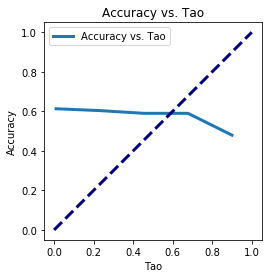

In [14]:
import matplotlib.pyplot as plot
figure = plot.figure()
axe = figure.gca()
axe.plot(tau_list, accuracies, lw=3, label="Accuracy vs. Tao")
axe.set_xlabel("Tao")
axe.set_ylabel("Accuracy")
axe.set_title("Accuracy vs. Tao")
axe.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
axe.legend()
axe.set_aspect('equal')

In [ ]:
import matplotlib.pyplot as plot
figure = plot.figure()
axe = figure.gca()
axe.plot(tau_list, mean_difference, lw=3,color='orange', label="Mean Bias Difference vs. Tao")
axe.set_xlabel("Tao")
axe.set_ylabel("Mean Bias Difference")
axe.set_title("Mean Bias Difference vs. Tao")
axe.plot([0, 1], [0, 0.1], color='navy', lw=3, linestyle='--')
axe.legend()
axe.set_aspect('equal')

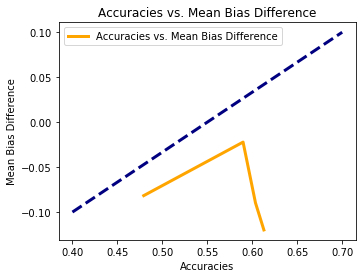

In [22]:
import matplotlib.pyplot as plot
figure = plot.figure()
axe = figure.gca()
axe.plot(accuracies, mean_difference, lw=3,color='orange', label="Accuracies vs. Mean Bias Difference")
axe.set_xlabel("Accuracies")
axe.set_ylabel("Mean Bias Difference")
axe.set_title("Accuracies vs. Mean Bias Difference")
axe.plot([0.4, 0.7], [-0.1, 0.1], color='navy', lw=3, linestyle='--')
axe.legend()
axe.set_aspect('equal')

#### Interpretation

The graph shows that, for almost all the Tao values, the accuracy goes down as the tao goes up. The mean bia difference is loves when tao is 0.88, coming all the way down to -0.015 from -0.19 biased model. We can clearly observe a trade-off between the accuracy score and bias reduction, as expected.

#### Other Metrices to Use
1. FDR (False Discovery Rate): is a method of conceptualizing the rate of type I errors in null hypothesis testing when conducting multiple comparisons. (from Wikipedia) The idea of false discovery rate is to make the total number of FALSE discoveries (false positive + false negative) LOWER as a percentage of the overall discoveries.

#### FDR Code Implementation

We implement the FDR metric to assess the "fairness" of the model from another bias related metric. Below we compare the best model from the iterations above, with the unconstrained model. This proves the reduction in bias. 

In [23]:
from aif360.algorithms.inprocessing.celisMeta.utils import getStats

#Unconstrained Model
mfc = MetaFairClassifier(tau=0, sensitive_attr="sex")
mfc.fit(dataset_orig_train)
dataset_bias_test = mfc.predict(dataset_orig_test)


predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in list(dataset_bias_test.labels)]
y_test = np.array([1 if y == [dataset_orig_train.favorable_label] else -1 for y in dataset_orig_test.labels])
x_control_test = pd.DataFrame(data=dataset_orig_test.features, columns=dataset_orig_test.feature_names)["sex"]

acc, sr, unconstrainedFDR = getStats(y_test, predictions, x_control_test)
print(unconstrainedFDR)

Accuracy :  3254 14653 0.777929434245547
SR tau :  0.24060062422550277
FPR tau :  0.43600739741090616
FNR tau :  0.8609189723320158
TPR tau :  0.31004901960784315
TNR tau :  0.980340417865866
AR tau :  0.8224361467717171
FDR tau :  0.4288194444444444
FOR tau :  0.3872744450835204
PPR tau :  0.4588815789473684
NPR tau :  0.8136439105306991
0.4288194444444444


In [25]:
# the best model from the iterations above had a TAO of 0.88.
mfc = MetaFairClassifier(tau=0.88, sensitive_attr="sex")
mfc.fit(dataset_orig_train)
dataset_bias_test = mfc.predict(dataset_orig_test)

predictions = list(dataset_bias_test.labels)
predictions = [1 if y == dataset_orig_train.favorable_label else -1 for y in predictions]
y_test = np.array([1 if y == [dataset_orig_train.favorable_label] else -1 for y in dataset_orig_test.labels])
x_control_test = pd.DataFrame(data=dataset_orig_test.features, columns=dataset_orig_test.feature_names)["sex"]

acc, sr, fdr = getStats(y_test, predictions, x_control_test)
print(fdr, unconstrainedFDR)

Accuracy :  6660 14653 0.5454855660956801
SR tau :  0.9683859899039216
FPR tau :  0.9120522139618913
FNR tau :  0.6842461122379986
TPR tau :  0.9711585968379447
TNR tau :  0.8803995524643298
AR tau :  0.7673932778424438
FDR tau :  0.6863407379682039
FOR tau :  0.2292871682218505
PPR tau :  0.3786416244779234
NPR tau :  0.9379752173348904
0.6863407379682039 0.4288194444444444


In [26]:
assert(fdr >= unconstrainedFDR)

#### The statement above checks that the fdr with the balancing TAO gives better results than the unconstrained model in terms of fairness. 

In [36]:
mfc.__dict__['_params']

{'tau': 0.88, 'sensitive_attr': 'sex'}

# Comparison with a Logistic Regression

#### The comparison of the model at hand with the logistic regression comes from their similarity. Similar to Logistic Regression Classifier, Meta Fair Classfier calculates loss by trying to minimize a term (bias). And therefore, the algorithms work very similarly. We do not preprocess the data for the model to be similar to the Meta Fair Classifier example.

#### In the cells below you will see the logistic regression with the sensitive vairable "sex" and without the variable (variable was deleted). 

## With sensitive variable "sex"

In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


df_test = pd.DataFrame.from_records(dataset_orig_test.features)
df_test["labels"] = np.concatenate(dataset_orig_test.labels, axis=0)
y_test = df_test["labels"]
X_test = df_test.drop(["labels"],axis=1) 

df_train = pd.DataFrame.from_records(dataset_orig_train.features)
df_train["labels"] = np.concatenate(dataset_orig_train.labels, axis=0)
y_train = df_train["labels"]
X_train = df_train.drop(["labels"],axis=1)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
preds = clf.predict(X_test)
print("Accuracy Score:", round(accuracy_score(preds, y_test),3))

Accuracy Score: 0.793


#### Feature Importance (Permutation Test)

In [94]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(clf, random_state=0).fit(X_train, y_train)
eli5.show_weights(perm)

Weight,Feature
0.0649 ± 0.0030,x1
0.0242 ± 0.0015,x0
0.0199 ± 0.0011,x2


## Without sensitive variable "sex"

In [95]:
y_train = df_train["labels"]
X_train = df_train.drop(["labels", 2],axis=1)
y_test = df_test["labels"]
X_test = df_test.drop(["labels", 2],axis=1) 

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
preds = clf.predict(X_test)
print("Accuracy Score without the sensitive variable:", round(accuracy_score(preds, y_test),3))

Accuracy Score without the sensitive variable: 0.778


#### Feature Importance (Permutation Test)

In [96]:
perm = PermutationImportance(clf, random_state=0).fit(X_train, y_train)
eli5.show_weights(perm)

Weight,Feature
0.0584 ± 0.0031,x1
0.0219 ± 0.0027,x0


## Correlation Among Variables
#### "2" is the SEX variable

In [97]:
round(df.corr(),3)

,0,1,2,labels
0,1.000,0.032,0.091,0.231
1,0.032,1.000,0.012,0.335
2,0.091,0.012,1.000,0.214
labels,0.231,0.335,0.214,1.000


## Interpretation

### From the analysis and comparison above we come to a very important conclusion, that serves as the krux of our bias/fairness discussion. As we can see above, the logistic regression model, that works similar to Meta Fair Classifier (through minimizing an error term), achieves a much higher accuracy than MFC. Accuracy of the unconstrained model in MFC is almost the same as the accuracy of the Logistic Regression without the SEX variable. We can also see this in the Global Feature Importance graphs of the two logistic regression models. The reason both of these models have higher and very similar accuracies is because SEX is actually not a very preditive variable. This is proven by the global feature importance diagrams (0.0199) concoted through a Permuttion test.

### While the imputation of the sensitive variable serves as a loss of data, we can see that it also erases bias. However, erasing sensitive variables is not enough to erase bias in most of the cases. To make sure that there is no inter variable dependency such that the deleted variable is highly corraleted with another variable, which vauses a indirect bias, we created a correlation graph above. On it, we see that none of the other two predictors are strongly correlated with the sensitive variable "Sex". 

### Overall it is important to keep these strategies in mind and decide WHEN and HOW to use IBM's algorithms. In some cases such as the one I just walked you through, using a logistic regression and imputing the SEX variale yields less bias and higher accuracy than any IBM algorithm.